## 5.1 Single-Line

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pylab as plt
import utils

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

Generate the data:

In [2]:
ds = [-0.05, ] # A; EWs, sort-of
ms = [5000.0, ] # A; line centers
sigs = [0.05, ] # A; line sigmas
dx = 0.01 # A; wavelength grid spacing
xs = np.arange(4992. + 0.5 * dx, 5008., dx) # A
N = 64
snr = 150.
data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)

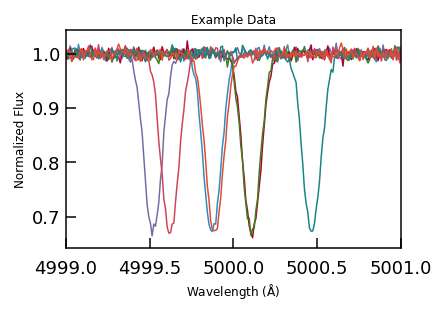

In [3]:
for n in range(0,N,10):
    plt.plot(xs, data[n])
plt.xlim([4999.,5001.])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

Calculate CRLB:

In [4]:
crlb = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
print "CRLB:", crlb, "m/s"

CRLB: 29.3017494793 m/s


# How does the CRLB change as line FWHM changes?

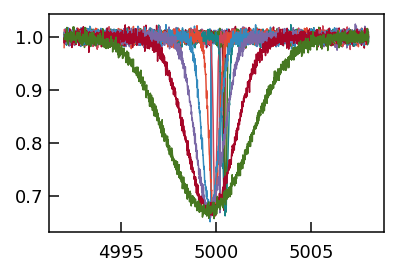

In [5]:
# grid of varying FWHMs:
all_sigs = np.logspace(-2, 0.3, 101)
all_fwhms = 2. * np.sqrt(2. * np.log(2.)) * all_sigs
all_ds = ds[0]/sigs[0] * all_sigs # must keep contrast fixed
# calculate CRLBs:
crlbs = np.zeros_like(all_sigs)
for i,(sig,d) in enumerate(zip(all_sigs, all_ds)):
    sigs[0] = sig
    ds[0] = d
    data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)
    crlbs[i] = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
    if (i % 10) == 0:
        plt.plot(xs, data[0])
# reset:
sigs = [0.05, ] # A
ds = [-0.05, ] # A

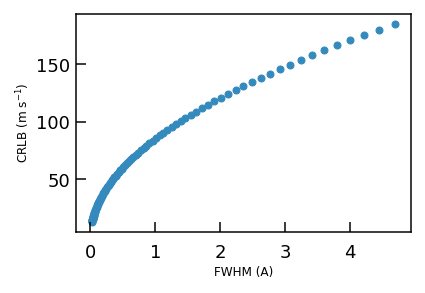

In [6]:
plt.scatter(all_fwhms, crlbs)
plt.xlabel('FWHM (A)')
plt.ylabel(r'CRLB (m s$^{-1}$)')

In [7]:
# fitting a sqrt function with linear algebra/magic
A = np.sqrt(all_fwhms)
ATA = np.dot(A, A)
ATy = np.dot(A, crlbs)
amp = ATy / ATA

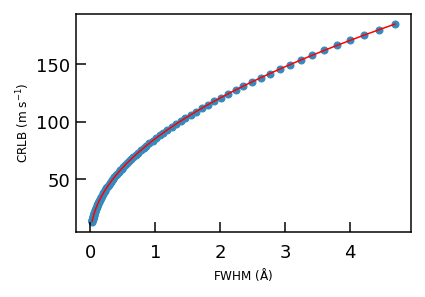

In [8]:
plt.scatter(all_fwhms, crlbs)
plt.plot(all_fwhms, amp * A, c='r')
plt.xlabel(r'FWHM ($\AA$)')
plt.ylabel(r'CRLB (m s$^{-1}$)')

# How does CRLB change as contrast changes?

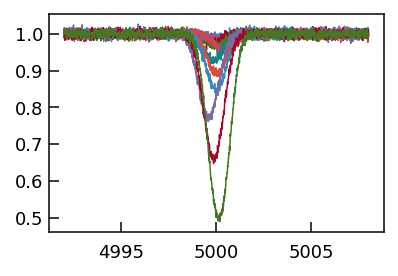

In [9]:
# grid of varying contrasts:
sigs[0] = 0.5 # work with a big line bc otherwise you can't see it at low contrast
all_cs = np.logspace(-2., -0.3, 101)
all_sigs = np.zeros_like(all_cs) + sigs[0]
all_ds = np.log(1. - all_cs) * all_sigs * sqrttwopi # hold FWHM fixed; trust us
# calculate CRLBs:
crlbs = np.zeros_like(all_cs)
for i,(d,sig) in enumerate(zip(all_ds,all_sigs)):
    ds[0] = d
    sigs[0] = sig
    data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)
    crlbs[i] = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
    if (i % 10) == 0:
        plt.plot(xs, data[0])
# reset:
sigs = [0.05, ] # A
ds = [-0.05, ] # A

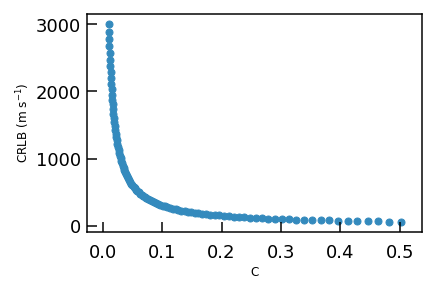

In [10]:
plt.scatter(all_cs, crlbs)
plt.xlabel('C')
plt.ylabel(r'CRLB (m s$^{-1}$)')

In [11]:
# fitting a 1/linear function with linear algebra/magic
A = 1.0/all_cs
ATA = np.dot(A, A)
ATy = np.dot(A, crlbs)
amp = ATy / ATA

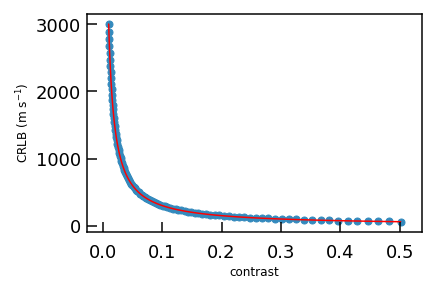

In [12]:
plt.scatter(all_cs, crlbs)
plt.plot(all_cs, amp * A, c='r')
plt.xlabel('contrast')
plt.ylabel(r'CRLB (m s$^{-1}$)')

# How does CRLB change as SNR changes?

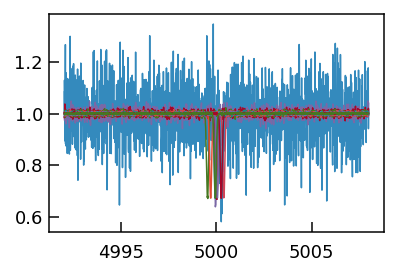

In [13]:
# grid of varying SNR:
all_snrs = np.linspace(10., 500., 101)
# calculate CRLBs:
crlbs = np.zeros_like(all_cs)
for i,s in enumerate(all_snrs):
    data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, s)
    crlbs[i] = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
    if (i % 10) == 0:
        plt.plot(xs, data[0])

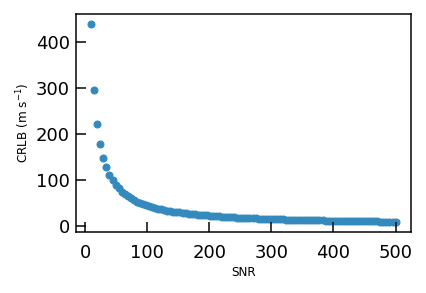

In [14]:
plt.scatter(all_snrs, crlbs)
plt.xlabel('SNR')
plt.ylabel(r'CRLB (m s$^{-1}$)')

In [15]:
# fitting a 1/linear function with linear algebra/magic
A = 1.0/all_snrs
ATA = np.dot(A, A)
ATy = np.dot(A, crlbs)
amp = ATy / ATA

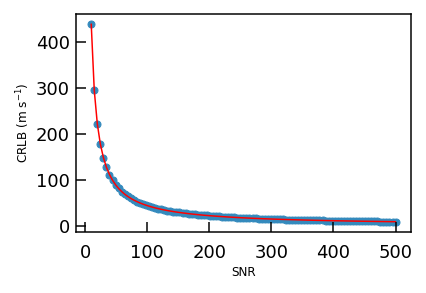

In [16]:
plt.scatter(all_snrs, crlbs)
plt.plot(all_snrs, amp * A, c='r')
plt.xlabel('SNR')
plt.ylabel(r'CRLB (m s$^{-1}$)')

Aww yeah.